In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklego.preprocessing import InformationFilter

# Fairness 

Scikit learn comes with the boston housing dataset. We can make a simple pipeline with it and make us a small model. We can even write the code to also make a plot that can convince us that we're doing well.

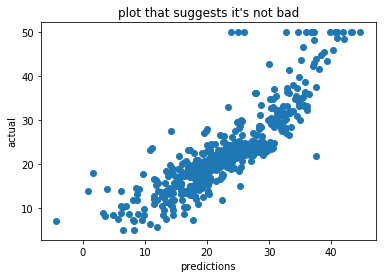

In [5]:
X, y = load_boston(return_X_y=True)

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", LinearRegression())
])

plt.scatter(pipe.fit(X, y).predict(X), y)
plt.xlabel("predictions")
plt.ylabel("actual")
plt.title("plot that suggests it's not bad");

We could stop our research here if we think that our MSE is "good enough" but this would be dangerous. To find out why, we should look at the variables that are being used in our model. 

In [6]:
print(load_boston()['DESCR'][:1200])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
! ls _static/projections.png

_static/projections.png


This dataset contains features like "lower status of population" and "the proportion of blacks by town". This is bad. There's a real possibility that our model will overfit on MSE and underfit on fairness when we want to apply it. Scikit-Lego has some support to deal with fairness issues like this one. 

## Information Filter

This is a great opportunity to use the `InformationFilter` which can filter the information of these two sensitive columns away as a transformation step. It does this by projecting all vectors away such that the remaining dataset is orthogonal to the sensitive columns.

### How it Works 

The `InformationFilter` uses a variant of the [gram smidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) to filter information out of the dataset. We can make it visual in two dimensions;

![](_static/projections.png)

To explain what occurs in higher dimensions we need to resort to maths. Take a training matrix $X$ that contains columns $x_1, ..., x_k$. If we assume columns $x_1$ and $x_2$ to be the sensitive columns then the information filter will filter out information using this approach; 

$$
\begin{split}
v_1 & = x_1 \\
v_2 & = x_2 - \frac{x_2 v_1}{v_1 v_1}\\
v_3 & = x_3 - \frac{x_k v_1}{v_1 v_1} - \frac{x_2 v_2}{v_2 v_2}\\
... \\ 
v_k & = x_k - \frac{x_k v_1}{v_1 v_1} - \frac{x_2 v_2}{v_2 v_2}
\end{split}
$$

Concatenating our vectors (but removing the sensitive ones) gives us a new training matrix $X_{\text{more fair}} =  [v_3, ..., v_k]$. 

### Experiment 

We will demonstrate the effect of applying this by benchmarking three things: 

1. Keep $X$ as is. 
2. Drop the two columns that are sensitive.
3. Use the information filter

In [8]:
df = pd.DataFrame(X, columns=['crim','zn','indus','chas','nox',
                              'rm','age','dis','rad','tax','ptratio',
                              'b','lstat'])
X_drop = df.drop(columns=["lstat", "b"])
X_fair = InformationFilter(["lstat", "b"]).fit_transform(df)
X_fair = pd.DataFrame(X_fair, 
                      columns=[n for n in df.columns if n not in ['b', 'lstat']])

Let's see what the effect is of three approaches: 

1. Keep $X$ as is. 
2. Drop the two columns that are sensitive.
3. Use $X_{\text{fair}}$ with orthogonal features.

In [9]:
def simple_mod():
    return Pipeline([("scale", StandardScaler()), ("mod", LinearRegression())])

base_mod = simple_mod().fit(X, y)
drop_mod = simple_mod().fit(X_drop, y)
fair_mod = simple_mod().fit(X_fair, y)

base_pred = base_mod.predict(X)
drop_pred = drop_mod.predict(X_drop)
fair_pred = fair_mod.predict(X_fair)

We can see that the coefficients of the three models are indeed different.

In [10]:
pd.DataFrame([base_mod.steps[1][1].coef_, drop_mod.steps[1][1].coef_, fair_mod.steps[1][1].coef_], columns=df.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.928146,1.081569,0.140900,0.681740,-2.056718,2.674230,0.019466,-3.104044,2.662218,-2.076782,-2.060607,0.849268,-3.743627
1,-1.581396,0.911004,-0.290074,0.884936,-2.567870,4.264702,-1.270735,-3.331836,2.215737,-2.056246,-2.154600,NaN,NaN
2,-0.763568,1.028051,0.061393,0.697504,-1.605464,6.846774,-0.057920,-2.537602,1.935058,-1.779825,-2.793069,NaN,NaN


#### Measuring Fairness

Measuring fairness can be done in many ways but we'll consider one definition: the output of the model is fair with regards to groups $A$ and $B$ if prediction has a distribution independant if group $A$ or $B$. In laymans terms: if group $A$ and $B$ don't get the same predictions: no bueno. 

To estimate this we'll use bootstrap sampling to measure the models bias. 

In [11]:
# we're using lstat to select the group to keep things simple
selector = df["lstat"] > np.quantile(df["lstat"], 0.5)

def bootstrap_means(preds, selector, n=2500, k=25):
    grp1 = np.random.choice(preds[selector], (n, k)).mean(axis=1)
    grp2 = np.random.choice(preds[~selector], (n, k)).mean(axis=1)
    return grp1 - grp2

#### 1. Original Situation

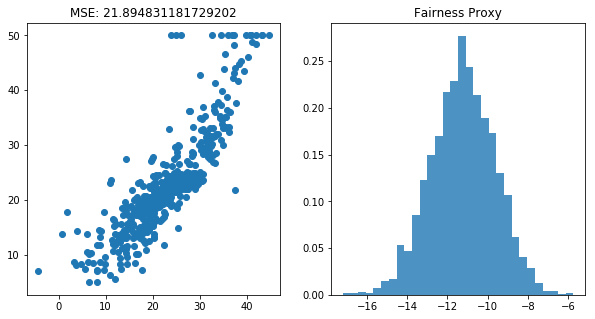

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(base_pred, y)
plt.title(f"MSE: {mean_squared_error(y, base_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

#### 2. Drop two columns

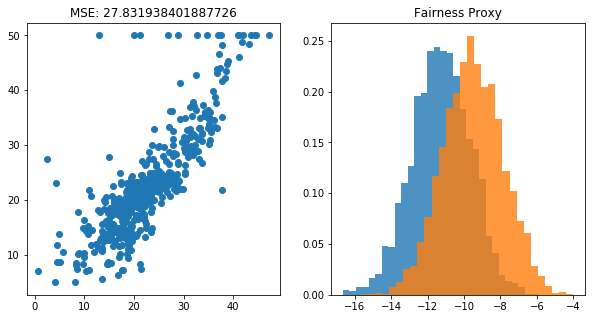

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(drop_pred, y)
plt.title(f"MSE: {mean_squared_error(y, drop_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(drop_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

#### 3. Use the Information Filter

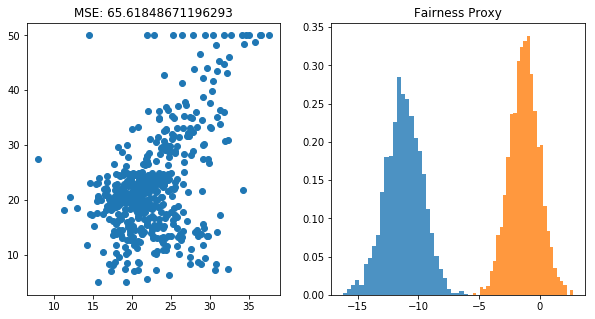

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(fair_pred, y)
plt.title(f"MSE: {mean_squared_error(y, fair_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(fair_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

There definately is a balance between fairness and model accuracy. Which model you'll use depends on the world you want to create by applying your model. 

Note that you can combine models here to make an ensemble too. You can also use the difference between the 1st and  last model as a proxy for bias.

## Fair Classifier

Another way we could tackle this fairness problem would be to explicitly take fairness into account when optimizing the parameters of our model. This is implemented in the `FairClassifier`.

### How it works
The `FairClassifier` is built as an extension of basic logistic regression. Where logistic regression optimizes the following problem:

$$\begin{array}{cl}
{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},\boldsymbol{\theta}\right)
\end{array}
$$

We would like to instead optimize this:

$$\begin{array}{cl}{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},
        \boldsymbol{\theta}\right)\\
{\text { subject to }} & \text{fairness} \geq \mathbf{c}\end{array}    $$  
        

A common way to measure fairness in classification tasks is the p% score:

$$\text{fairness} = \min \left(\frac{P(\hat{y}=1 | z=1)}{P(\hat{y}=1 | z=0)}, \frac{P(\hat{y}=1 | z=0)}{P(\hat{y}=1 | z=1)}\right)$$

The p% score is a nice metric but unfortunately it is rather hard to directly implement in the formulation into our model as it is a non-convex function making it difficult to optimize directly. Also, as the p% rule only depends on which side of the decision boundary an observation lies, it is invariant in small changes in the decision boundary. This causes large saddle points in the objective making optimization even more difficult

Instead of optimizing for the p% directly, we approximate it by taking the covariance between the users’ sensitive
attributes, $z$m, and the decision boundary. This results in the following formulation of our `FairClassifier`.

$$\begin{array}{cl}{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},
        \boldsymbol{\theta}\right)\\
{\text { subject to }} & {\frac{1}{N} \sum_{i=1}^{N}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right) d
        \boldsymbol{\theta}\left(\mathbf{x}_{i}\right) \leq \mathbf{c}} \\
        {} & {\frac{1}{N} \sum_{i=1}^{N}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right)
        d_{\boldsymbol{\theta}}\left(\mathbf{x}_{i}\right) \geq-\mathbf{c}}\end{array}    $$  
        

Let's see what the effect of this is. As this is a Classifier and not a Regressor, we transform the target to a binary variable indicating whether it is above or below the median. Our p% metric also assumes a binary indicator for sensitive columns so we do the same for our `lstat` column


In [46]:
from sklego.linear_model import FairClassifier
from sklearn.linear_model import LogisticRegression
from sklego.metrics import p_percent_score

df_clf = df.assign(lstat=lambda d: d['lstat'] > np.median(d['lstat']))
y_clf = y > np.median(y)

fair_classifier = FairClassifier(
    covariance_threshold=0.5, 
    sensitive_cols=['lstat'], 
    train_sensitive_cols=False)
normal_classifier = LogisticRegression(solver='lbfgs')

fair_classifier.fit(df_clf, y_clf)
normal_classifier.fit(df_clf, y_clf);

/Users/matthijsbrouns/PycharmProjects/scikit-lego/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


fitting the model is as easy as fitting a normal sklearn model. We just need to supply the columns that should be treated as sensitive to the model, as well as the maximum correlation we want to have. 

Comparing the two models on their p% scores also shows that the fair classifier has a much higher fairness score at a slight cost in accuracy

In [55]:
print('p% score FairClassifier:', p_percent_score('lstat')(fair_classifier, df_clf, y_clf))
print('p% score LogisticRegression:', p_percent_score('lstat')(normal_classifier, df_clf, y_clf))

p% score FairClassifier: 0.18000000000000002
p% score LogisticRegression: 0.08928571428571429


In [57]:
from sklearn.metrics import accuracy_score
print('accuracy score FairClassifier:', accuracy_score(fair_classifier.predict(df_clf), y_clf))
print('accuracy score LogisticRegression:', accuracy_score(normal_classifier.predict(df_clf), y_clf))

accuracy score FairClassifier: 0.8537549407114624
accuracy score LogisticRegression: 0.8656126482213439
